##**Методы машинного обучения для оценки содержания азота в растениях по аэрофотоснимкам**

Этот блокнот предназначен для обучения нейросетевых методов машинного обучения.

**Подключение необходимых библиотек**

In [1]:
try:
    import torchmetrics
except ImportError:
    !pip install torchmetrics
    import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import gdown
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

import torch
import torch.nn as nn
from torchmetrics import JaccardIndex
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torchvision.transforms.functional as TF
from IPython.display import clear_output
import math

**Загрузка данных**

In [3]:
synth_url = 'https://drive.google.com/uc?id=1cofQeepo06m3scui5aLkx_ch6Ti6CxLZ'
test_url = 'https://drive.google.com/uc?id=1--GE0W5X7i0c-08In3LcWZ-VdnYbvOTT'
synth_path = "train_images_and_masks.npz"
test_path = "test_images_and_masks.npz"
gdown.download(synth_url, synth_path, quiet=False)
gdown.download(test_url, test_path, quiet=False)
synth_data = np.load(synth_path)
test_data = np.load(test_path)
train_images = synth_data["synth_images"]
train_masks = synth_data["synth_masks"]
test_images = test_data["test_images"]
test_masks = test_data["test_masks"]

Downloading...
From (original): https://drive.google.com/uc?id=1cofQeepo06m3scui5aLkx_ch6Ti6CxLZ
From (redirected): https://drive.google.com/uc?id=1cofQeepo06m3scui5aLkx_ch6Ti6CxLZ&confirm=t&uuid=2f65a396-70f9-423e-9248-78b26ee3ecde
To: /content/train_images_and_masks.npz
100%|██████████| 298M/298M [00:03<00:00, 82.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--GE0W5X7i0c-08In3LcWZ-VdnYbvOTT
To: /content/test_images_and_masks.npz
100%|██████████| 6.28M/6.28M [00:00<00:00, 43.6MB/s]


**Проверка данных и визуализация изображений**

In [4]:
print(train_images.shape)
print(train_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(3000, 128, 128, 6)
(3000, 128, 128, 1)
(66, 128, 128, 6)
(66, 128, 128, 1)


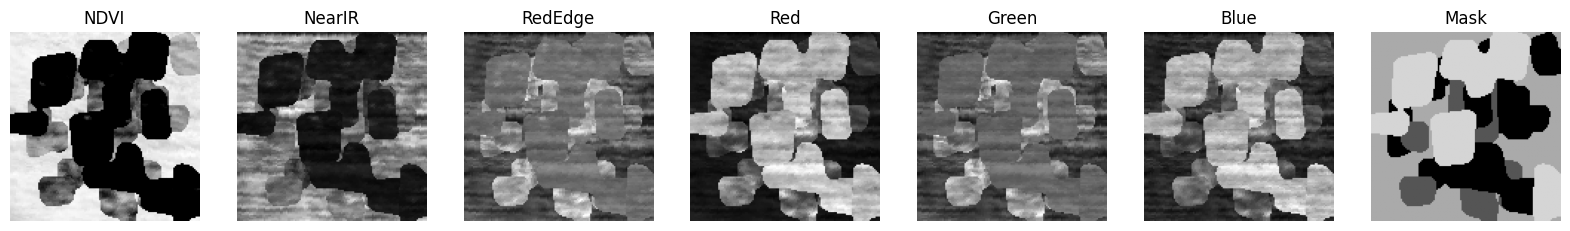

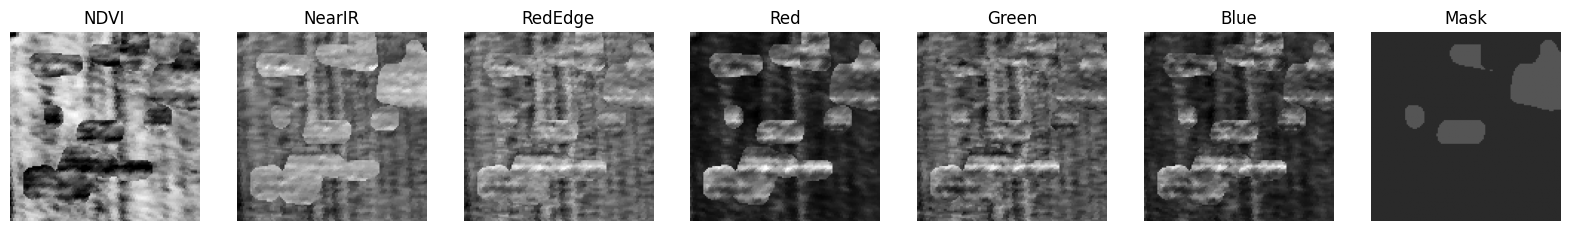

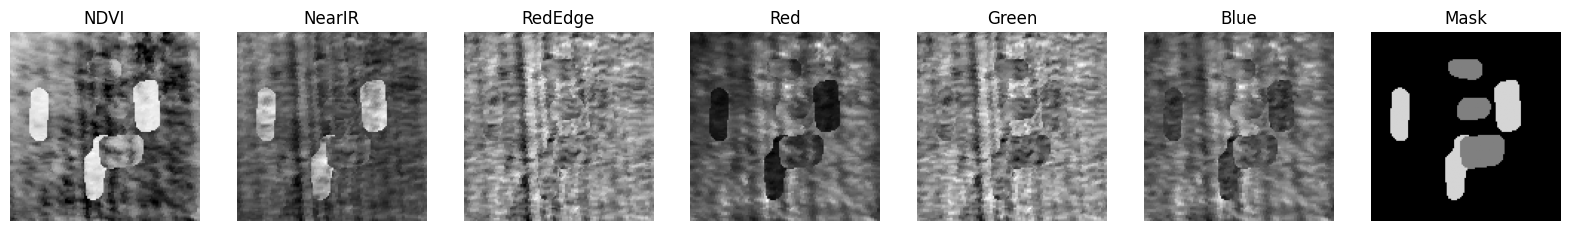

In [5]:
# Названия каналов для подписей
channel_names = ["NDVI", "NearIR", "RedEdge", "Red", "Green", "Blue"]

def visualize_samples(images, masks, num_samples=3):
    """
    Визуализирует несколько примеров изображений и их масок.

    Параметры:
    - images: numpy-массив изображений (размерность: [N, 128, 128, 6])
    - masks: numpy-массив масок (размерность: [N, 128, 128, 1])
    - num_samples: количество примеров для отображения
    """

    for i in range(num_samples):
        img = images[i]  # Берём одно изображение (6 каналов)
        mask = masks[i].squeeze()  # Убираем лишнюю ось (128, 128)

        fig, ax = plt.subplots(1, 7, figsize=(20, 5))

        # Визуализируем все 6 каналов с подписями
        for j in range(6):
            ax[j].imshow(img[:, :, j], cmap="gray")
            ax[j].set_title(channel_names[j])  # Добавляем подпись
            ax[j].axis("Off")

        # Визуализируем маску (размеченные классы)
        ax[-1].imshow(mask, cmap="gray", vmin=0, vmax=6)
        ax[-1].set_title("Mask")
        ax[-1].axis("Off")

        plt.show()

# Вызываем функцию для отображения 3 примеров
visualize_samples(train_images, train_masks)

**Создание генераторов для аугментации изображений**

Для аугментации используются стандартные методы поворота до 90 градусов, смещения и отражения из библиотеки ImageDataGenerator.
Также мы выделяем валидационную выборку, которую будем использовать для контроля темпа обучения.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)

X_test = test_images
y_test = test_masks

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2700, 128, 128, 6) (2700, 128, 128, 1)
(300, 128, 128, 6) (300, 128, 128, 1)
(66, 128, 128, 6) (66, 128, 128, 1)


In [7]:
data_gen_args = dict(
    rotation_range=90,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    horizontal_flip=True
)

train_image_datagen = ImageDataGenerator(**data_gen_args)
train_mask_datagen = ImageDataGenerator(**data_gen_args)
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()
test_image_datagen = ImageDataGenerator()
test_mask_datagen = ImageDataGenerator()

In [8]:
train_image_generator = train_image_datagen.flow(X_train, batch_size=32, seed=42)
train_mask_generator = train_mask_datagen.flow(y_train, batch_size=32, seed=42)
val_image_generator = val_image_datagen.flow(X_val, batch_size=32, seed=42)
val_mask_generator = val_mask_datagen.flow(y_val, batch_size=32, seed=42)
test_image_generator = test_image_datagen.flow(X_test, batch_size=32, shuffle=False, seed=42)
test_mask_generator = test_mask_datagen.flow(y_test, batch_size=32, shuffle=False, seed=42)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2700, 128, 128, 6) (6 channels).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (300, 128, 128, 6) (6 channels).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (66, 128, 128, 6) (6 chann

Объединяем генератор для изображений и масок, чтобы синхронизировать аугментацию.

In [9]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

**Проверка тренировочных генераторов и визуализация изображений и масок**

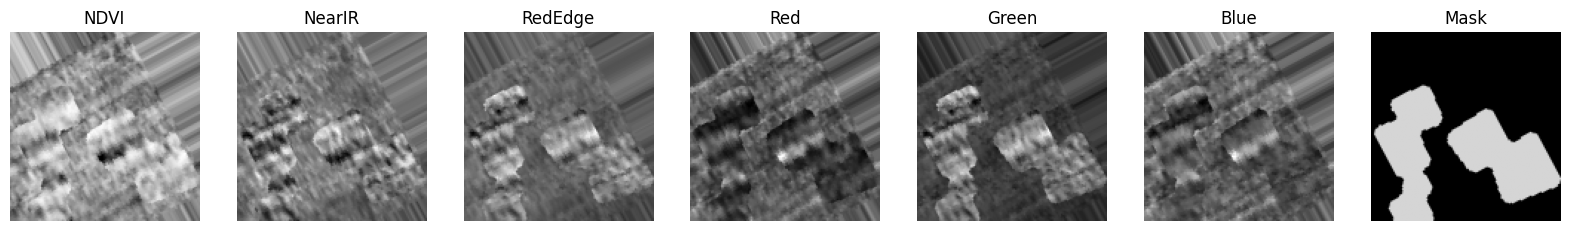

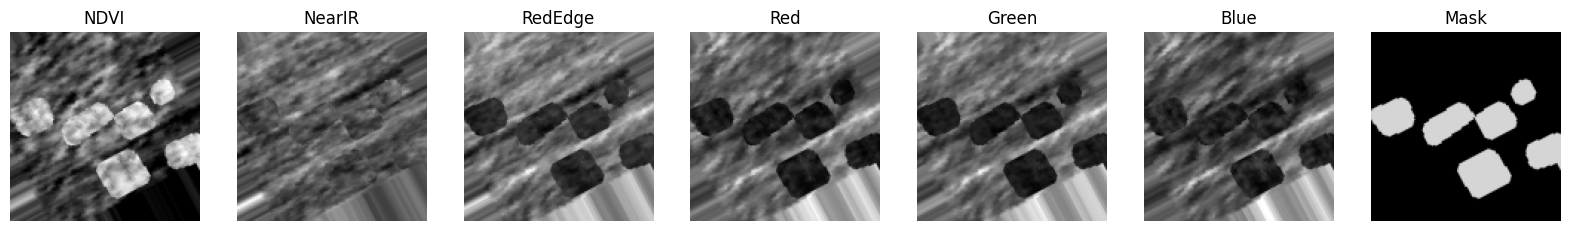

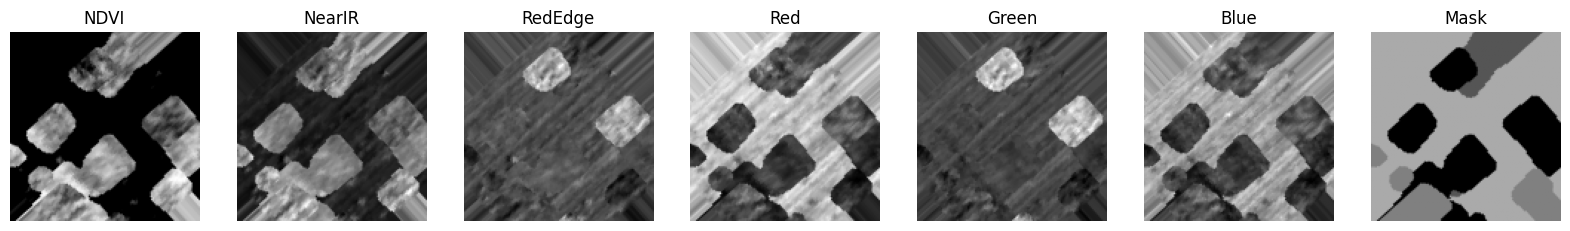

In [10]:
# Названия каналов для подписей
channel_names = ["NDVI", "NearIR", "RedEdge", "Red", "Green", "Blue"]

# Получаем один батч
images, masks = next(train_generator)

def visualize_samples(images, masks, num_samples=3):
    """
    Визуализирует несколько примеров изображений и их масок.

    Параметры:
    - images: numpy-массив изображений (размерность: [N, 128, 128, 6])
    - masks: numpy-массив масок (размерность: [N, 128, 128, 1])
    - num_samples: количество примеров для отображения
    """
    for i in range(num_samples):
        img = images[i]  # Берём одно изображение (6 каналов)
        mask = masks[i].squeeze()  # Убираем лишнюю ось (128, 128)

        fig, ax = plt.subplots(1, 7, figsize=(20, 5))

        # Визуализируем все 6 каналов с подписями
        for j in range(6):
            ax[j].imshow(img[:, :, j], cmap="gray")
            ax[j].set_title(channel_names[j])  # Добавляем подпись
            ax[j].axis("Off")

        # Визуализируем маску
        ax[-1].imshow(mask, cmap="gray", vmin=0, vmax=6)
        ax[-1].set_title("Mask")
        ax[-1].axis("Off")

        plt.show()

visualize_samples(images, masks, num_samples=3)

**Проверка валидационных генераторов и визуализация изображений и масок**

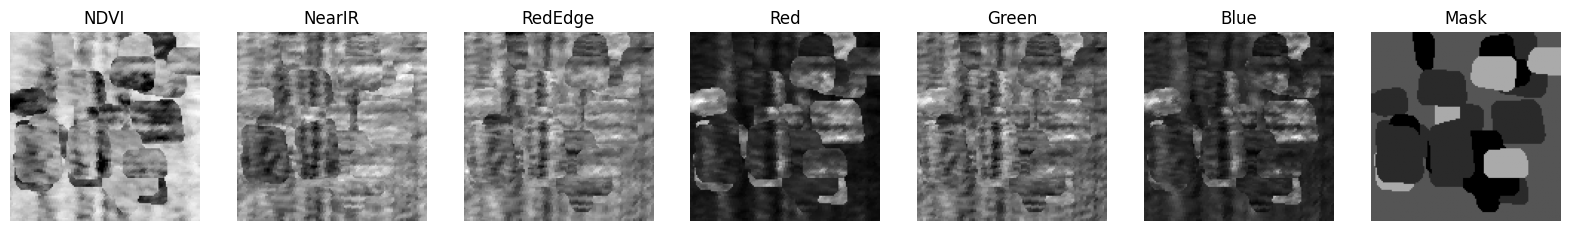

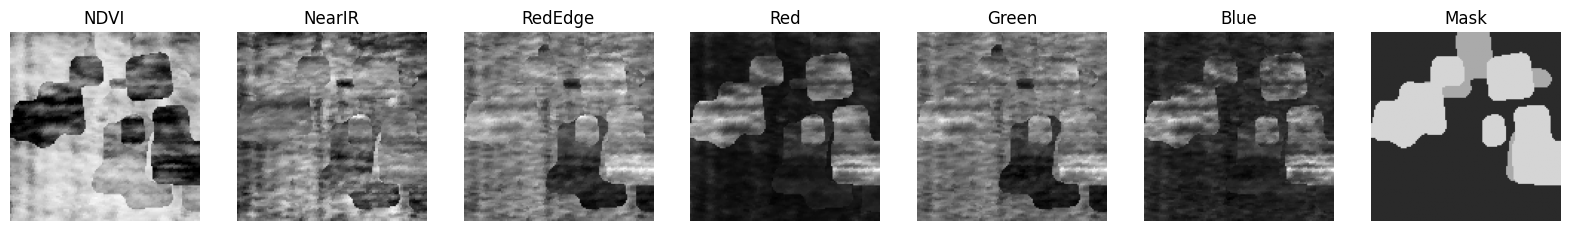

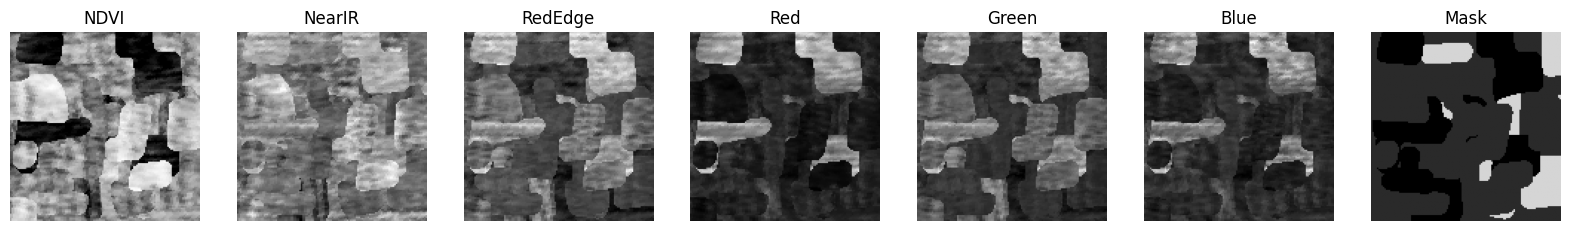

In [11]:
# Названия каналов для подписей
channel_names = ["NDVI", "NearIR", "RedEdge", "Red", "Green", "Blue"]

# Получаем один батч
sample_batch = next(val_generator)
images, masks = sample_batch

def visualize_samples(images, masks, num_samples=3):
    """
    Визуализирует несколько примеров изображений и их масок.

    Параметры:
    - images: numpy-массив изображений (размерность: [N, 128, 128, 6])
    - masks: numpy-массив масок (размерность: [N, 128, 128, 1])
    - num_samples: количество примеров для отображения
    """
    for i in range(num_samples):
        img = images[i]  # Берём одно изображение (6 каналов)
        mask = masks[i].squeeze()  # Убираем лишнюю ось (128, 128)

        fig, ax = plt.subplots(1, 7, figsize=(20, 5))

        # Визуализируем все 6 каналов с подписями
        for j in range(6):
            ax[j].imshow(img[:, :, j], cmap="gray")
            ax[j].set_title(channel_names[j])  # Добавляем подпись
            ax[j].axis("Off")

        # Визуализируем маску
        ax[-1].imshow(mask, cmap="gray", vmin=0, vmax=6)
        ax[-1].set_title("Mask")
        ax[-1].axis("Off")

        plt.show()

visualize_samples(images, masks, num_samples=3)

К данным из валидационной выборки аугментация не применяется

**Подключение к графическому процессору для обучения нейросетей**

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Архитектура U-Net**

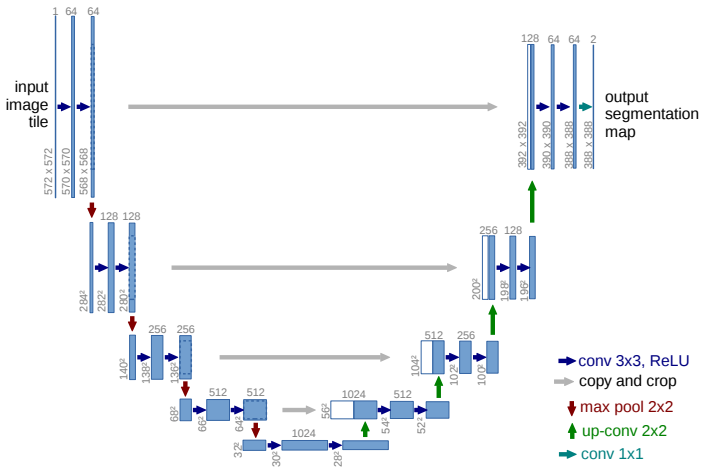

In [13]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

In [14]:
class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):

    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)

      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

**Тест архитектуры**

In [15]:
def test():
  x = torch.randn((3, 1, 161, 161))
  model = UNet(in_channels=1, out_channels=1)
  preds = model(x)
  assert preds.shape == x.shape

test()

**Функция обучения**

In [22]:
def train(model, opt, loss_fn, epochs, train_generator, val_generator, steps_per_epoch, val_steps):
    """
    Обучает модель на основе переданных параметров.

    Аргументы:
    - model: нейросеть (torch.nn.Module)
    - opt: оптимизатор (torch.optim)
    - loss_fn: функция потерь
    - epochs: количество эпох
    - train_generator: генератор тренировочных данных
    - val_generator: генератор валидационных данных
    - steps_per_epoch: количество итераций за эпоху обучения
    - val_steps: количество итераций для валидации

    Возвращает:
    - train_losses: список значений функции потерь на обучении
    - val_losses: список значений функции потерь на валидации
    - train_ious: список значений IoU на обучении
    - val_ious: список значений IoU на валидации
    """
    train_losses = []  # Список для хранения потерь на обучении
    val_losses = []  # Список для хранения потерь на валидации
    train_ious = []  # Список для хранения IoU на обучении
    val_ious = []  # Список для хранения IoU на валидации

    # Метрики IoU (Jaccard Index) для оценки сегментации
    train_iou_metric = JaccardIndex(task="multiclass", num_classes=6).to(device)
    val_iou_metric = JaccardIndex(task="multiclass", num_classes=6).to(device)

    # Планировщик обучения для уменьшения LR, если метрика не улучшается
    scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, verbose=True)

    # Извлекаем один batch для визуализации
    X_vis, y_vis = next(val_generator)
    X_vis, y_vis = torch.tensor(X_vis), torch.tensor(y_vis)
    X_vis = X_vis.permute(0, 3, 1, 2)  # Меняем порядок осей (H, W, C -> C, H, W)
    y_vis = y_vis.squeeze(dim=3)  # Убираем лишнюю размерность

    for epoch in range(epochs):
        print('Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()
        train_iou_metric.reset()

        # Обучение модели
        for step in tqdm(range(steps_per_epoch), desc='Training'):
            X_batch, y_batch = next(train_generator)
            X_batch = torch.tensor(X_batch).permute(0, 3, 1, 2).to(device)
            y_batch = torch.tensor(y_batch).squeeze(dim=3).to(device)
            y_batch = y_batch.long()

            opt.zero_grad()  # Обнуляем градиенты
            y_pred = model(X_batch)  # Предсказание модели
            loss = loss_fn(y_pred, y_batch)  # Вычисление функции потерь
            loss.backward()  # Обратное распространение ошибки
            opt.step()  # Обновление весов

            avg_loss += loss.item() / steps_per_epoch
            preds = torch.argmax(y_pred, dim=1)  # Преобразуем в классы
            train_iou_metric.update(preds, y_batch)

        # Сохраняем метрики
        train_losses.append(avg_loss)
        train_ious.append(train_iou_metric.compute().item())
        print('Average train loss: %f | Train IoU: %f' % (avg_loss, train_ious[-1]))

        # Валидация модели
        model.eval()
        val_loss = 0
        val_iou_metric.reset()
        with torch.no_grad():
            for step in range(val_steps):
                X_val, y_val = next(val_generator)
                X_val = torch.tensor(X_val).permute(0, 3, 1, 2).to(device)
                y_val = torch.tensor(y_val).squeeze(dim=3).to(device)
                y_val = y_val.long()

                y_pred = model(X_val)
                val_loss += loss_fn(y_pred, y_val).item() / val_steps
                y_pred_iou = torch.argmax(y_pred, dim=1)
                val_iou_metric.update(y_pred_iou, y_val)

        val_losses.append(val_loss)
        val_ious.append(val_iou_metric.compute().item())
        print('Validation loss: %f | Validation IoU: %f' % (val_loss, val_ious[-1]))

        # Адаптивное изменение learning rate
        scheduler.step(val_loss)

        # Визуализация сегментации
        X_vis = X_vis.to(device)
        y_vis = y_vis.to(device)
        y_vis = y_vis.long()

        with torch.no_grad():
            y_pred_vis = model(X_vis)
            y_pred_vis = torch.argmax(y_pred_vis, dim=1).cpu()

        X_vis = X_vis.cpu()
        y_vis = y_vis.cpu()

        clear_output(wait=True)
        fig, ax = plt.subplots(3, 6, figsize=(9, 6))
        fig.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, val_loss))

        for i in range(6):
            img = X_vis[i][0].numpy()
            ax[0, i].imshow(img, cmap='gray')
            ax[0, i].axis('Off')
            ax[0, i].set_title('Input')

            ax[1, i].imshow(y_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
            ax[1, i].axis('Off')
            ax[1, i].set_title('Real mask')

            ax[2, i].imshow(y_pred_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
            ax[2, i].axis('Off')
            ax[2, i].set_title('Predicted mask')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

    # Графики потерь и IoU
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_ious, label='Train IoU')
    plt.plot(val_ious, label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('IoU')

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_ious, val_ious

In [23]:
# Вычисляем количество шагов (batch-ов) на каждую эпоху
steps_per_epoch = math.ceil(X_train.shape[0] / 32)  # Количество batch-ов в обучающем наборе
val_steps = math.ceil(X_val.shape[0] / 32)  # Количество batch-ов валидации
test_steps = math.ceil(X_test.shape[0] / 32)  # Количество batch-ов для тестирования

In [24]:
# Функция потерь — кросс-энтропия, подходит для многоклассовой сегментации
loss = nn.CrossEntropyLoss()

In [25]:
def train_model(max_epochs, loss, train_generator, val_generator, lr=1e-4):
    """
    Подготавливает и обучает модель U-Net для сегментации изображений.

    Аргументы:
    - max_epochs: количество эпох обучения
    - train_generator: генератор тренировочных данных
    - val_generator: генератор валидационных данных
    - lr: скорость обучения (learning rate), по умолчанию 1e-4

    Возвращает:
    - train_losses: список значений функции потерь на обучении
    - val_losses: список значений функции потерь на валидации
    - train_ious: список значений IoU на обучении
    - val_ious: список значений IoU на валидации
    """

    # Инициализация модели U-Net с 6 входными каналами (спектры) и 6 выходными классами
    model = UNet(in_channels=6, out_channels=6).to(device)

    # Оптимизатор Adam для обновления весов модели
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Запуск процесса обучения модели
    return train(model, opt, loss, max_epochs, train_generator, val_generator, steps_per_epoch, val_steps)

In [26]:
def evaluate_on_test(model, loss_fn, test_generator, test_steps):
  test_iou_metric = JaccardIndex(task="multiclass", num_classes=6).to(device)
  model.eval()
  test_loss = 0
  test_iou_metric.reset()
  with torch.no_grad():
    for step in range(test_steps):
      X_test, y_test = next(test_generator)
      X_test = torch.tensor(X_test).permute(0, 3, 1, 2).to(device)
      y_test = torch.tensor(y_test).squeeze(dim=3).to(device)
      y_test = y_test.long()
      y_pred = model(X_test)
      y_pred_iou = torch.argmax(y_pred, dim=1)
      test_iou_metric.update(y_pred_iou, y_test)

  X_vis, y_vis = next(test_generator)
  X_vis = torch.tensor(X_vis).permute(0, 3, 1, 2).to(device)
  y_vis = torch.tensor(y_vis).squeeze(dim=3).to(device)
  y_vis = y_vis.long()

  with torch.no_grad():
    y_pred_vis = model(X_vis)
    y_pred_vis = torch.argmax(y_pred_vis, dim=1).cpu()

  X_vis = X_vis.cpu()
  y_vis = y_vis.cpu()

  clear_output(wait=True)
  fig, ax = plt.subplots(3, 6, figsize=(9, 6))

  for i in range(6):

    img = X_vis[i][0].numpy()

    ax[0, i].imshow(img, cmap='gray')
    ax[0, i].axis('Off')
    ax[0, i].set_title('Input')

    ax[1, i].imshow(y_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
    ax[1, i].axis('Off')
    ax[1, i].set_title('Real mask')

    ax[2, i].imshow(y_pred_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
    ax[2, i].axis('Off')
    ax[2, i].set_title('Predicted mask')

  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

  test_accuracy = test_iou_metric.compute().item()
  print('Test Accuracy: %f' % test_accuracy)
  return test_accuracy

**Эксперименты с обучением модели U-Net на разном количестве эпох**

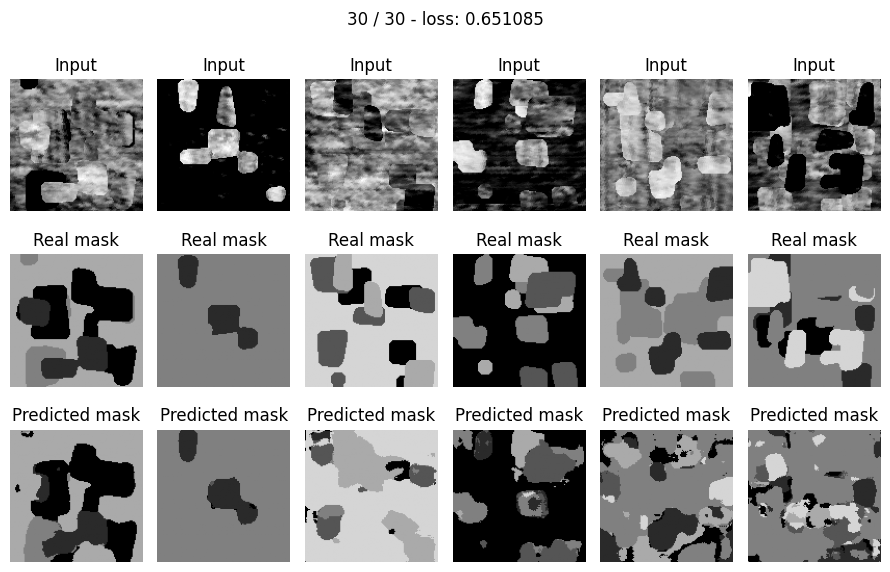

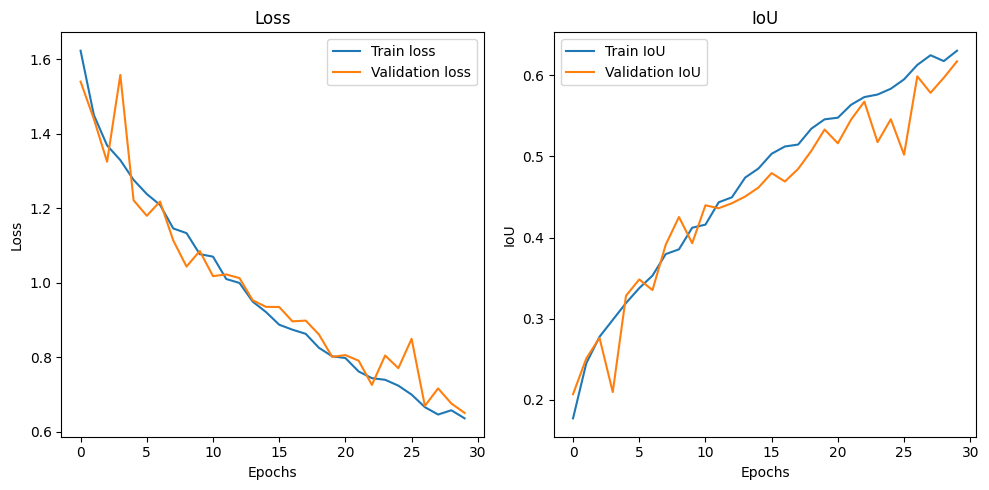

In [31]:
model, *train_data = train_model(max_epochs=30, loss=loss, train_generator=train_generator, val_generator=val_generator, lr=1e-4)

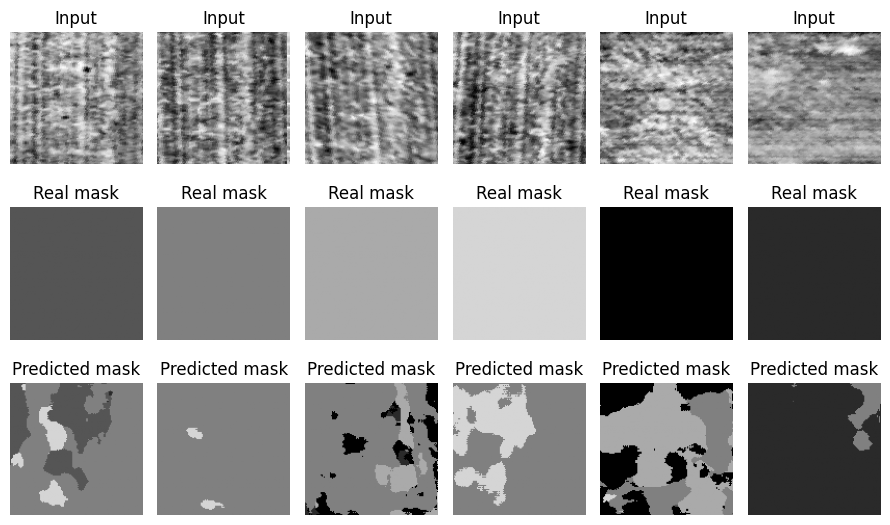

Test Accuracy: 0.321723


In [32]:
test = evaluate_on_test(model, loss, test_generator, test_steps)